# Anchored CorEx: Topic Modeling with Minimal Domain Knowledge

**Author:** [Ryan J. Gallagher](http://ryanjgallagher.github.io/)  

**Last updated:** 07/21/2018

This notebook walks through how to use the CorEx topic model code. This includes fitting CorEx to your data, examining the topic model output, outputting results, building a hierarchical topic model, and anchoring words to topics.

Details of the CorEx topic model and evaluations against unsupervised and semi-supervised variants of LDA can be found in our TACL paper:

Gallagher, Ryan J., Kyle Reing, David Kale, and Greg Ver Steeg. "[Anchored Correlation Explanation: Topic Modeling with Minimal Domain Knowledge](https://www.transacl.org/ojs/index.php/tacl/article/view/1244)." *Transactions of the Association for Computational Linguistics (TACL)*, 2017.

In [1]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt

from corextopic import corextopic as ct
from corextopic import vis_topic# jupyter notebooks will complain matplotlib is being loaded twice

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

import pandas as pd
from sklearn.feature_extraction import text


## Loading the 20 Newsgroups Dataset

We need to first load data to run the CorEx topic model. We'll use the 20 Newsgroups dataset, which scikit-learn provides functionality to access.

In [2]:
data = pd.read_csv('../Data/RYANDATA_filt.csv')
data.columns = ['V0', 'topic', 'authors','title','journal','year','vol_issue','doi','abstract']
print(data.groupby('topic')['title'].nunique())

topic
BONE                              1957
CARDIOVASCULAR/CARDIOPULMONARY    1164
CELLULAR/SUBCELLULAR              1217
COMPARATIVE                       1602
DENTAL/ORAL/FACIAL                1346
ERGONOMICS                         502
EVOLUTION/ANTHROPOLOGY             998
GAIT/LOCOMOTION                   3184
JOINT/CARTILAGE                   1429
METHODS                           1440
MODELING                          1240
MUSCLE                             705
NEURAL                            1705
ORTHOPAEDICS/SPINE                2286
ORTHOPAEDICS/SURGERY              3056
PROSTHETICS/ORTHOTICS              554
REHABILITATION                    1176
ROBOTICS                          1059
SPORT/EXERCISE                    2810
TENDON/LIGAMENT                   1551
TISSUE/BIOMATERIAL                2117
TRAUMA/IMPACTTESTING               690
VETERINARY/AGRICULTURAL            702
VISUAL/VESTIBULAR/EYE              777
Name: title, dtype: int64


In [3]:
#split data keeping distribution
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits= 1, 
                             test_size = 0.2, 
                             random_state = 0)

for train_idx, test_idx in sss.split(data['title'],data['topic']):
    X_train, X_test = data['title'][train_idx], data['title'][test_idx]
    y_train, y_test = data['topic'][train_idx], data['topic'][test_idx]


y_train.value_counts() #same distribution as original data

GAIT/LOCOMOTION                   2547
ORTHOPAEDICS/SURGERY              2445
SPORT/EXERCISE                    2248
ORTHOPAEDICS/SPINE                1829
TISSUE/BIOMATERIAL                1693
BONE                              1565
NEURAL                            1364
COMPARATIVE                       1281
TENDON/LIGAMENT                   1241
METHODS                           1152
JOINT/CARTILAGE                   1143
DENTAL/ORAL/FACIAL                1077
MODELING                           992
CELLULAR/SUBCELLULAR               974
REHABILITATION                     941
CARDIOVASCULAR/CARDIOPULMONARY     931
ROBOTICS                           847
EVOLUTION/ANTHROPOLOGY             798
VISUAL/VESTIBULAR/EYE              622
MUSCLE                             564
VETERINARY/AGRICULTURAL            562
TRAUMA/IMPACTTESTING               552
PROSTHETICS/ORTHOTICS              443
ERGONOMICS                         402
Name: topic, dtype: int64

In [4]:
#https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
# from nltk.stem.porter import *
import numpy as np
np.random.seed(0)

# import nltk
# nltk.download('wordnet')

#tokenize, lemmatized, stemmed
stemmer = SnowballStemmer(language='english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
#             result.append(lemmatize_stemming(token))
            result.append(token)
    result = ' '.join(result)        
    return result

doc_sample = X_train[0]
print('Original document: ')
words = []
for doc in [doc_sample]:
    print(doc)
print('\nTokenized and lemmatized document: ')
print(preprocess(doc_sample),'\n')

X_train_proc = X_train.map(preprocess)

train_data = pd.DataFrame({'title':X_train_proc, 'topic':y_train})
train_data
                      
          
         

Original document: 
Proximal radius fracture morphology following axial force impact: a biomechanical evaluation of fracture patterns

Tokenized and lemmatized document: 
proximal radius fracture morphology following axial force impact biomechanical evaluation fracture patterns 



,title,topic
8793,overcoming limitations harmonic ratio reliable...,GAIT/LOCOMOTION
6411,influence different abutment designs biomechan...,DENTAL/ORAL/FACIAL
24002,content validation clinical assessment instrum...,REHABILITATION
35014,neural control adaptive neural forward models ...,ROBOTICS
16312,dual developmental origin spinal cerebrospinal...,NEURAL
21506,remplissage versus latarjet engaging hill sach...,ORTHOPAEDICS/SURGERY
3450,aquantitative image analysis cellular cytoskel...,CELLULAR/SUBCELLULAR
34341,gait trajectory rolling planning control hexap...,ROBOTICS
11238,functional properties chondrocytes articular c...,JOINT/CARTILAGE
4816,effect foot posture capacity apply free moment...,COMPARATIVE


The topic model assumes input is in the form of a doc-word matrix, where rows are documents and columns are binary counts. We'll vectorize the newsgroups data, take the top 20,000 words, and convert it to a sparse matrix to save on memory usage. Note, we use binary count vectors as input to the CorEx topic model.

In [5]:
#transform title data into sparse matrix
#additional stop words
stop_words = text.ENGLISH_STOP_WORDS.union(['biomechanics','biomechanical','locomotor','locomotion','study'])
#CountVectorizer
vectorizer = CountVectorizer(min_df=3,
                            max_df=0.5,
                            max_features= 20000,
                            ngram_range=(1,3),
                            strip_accents='unicode',
                            lowercase=True,
                            analyzer='word',
                            stop_words=stop_words,
                            token_pattern= '[a-zA-Z-0-9]{3,}',
                            #TRY BINARY = TRUE
                           )
doc_word = vectorizer.fit_transform(train_data['title'])
doc_word = ss.csr_matrix(doc_word)
doc_word.shape # n_docs x m_words


(28213, 20000)

In [135]:
#get common words for each topic
n_top_topics = 3
title_subset = []
top_words = []
freq_list = []
words_freq = []
for i in train_data.groupby('topic'):
    title_subset.append(i)
for a in title_subset:  
    a # all titles in a given topic
    bag_of_words = vectorizer.transform(a[1]['title'])
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    words_freq = words_freq[:n_top_topics]
    for item in list(zip(*words_freq))[0]:
        freq_list.append(item)

freq_list = [freq_list[i:i + n_top_topics] for i in range(0, len(freq_list), n_top_topics)]

In [151]:
anchor_list = pd.DataFrame({'top_words':freq_list})
anchor_list.iloc[0]['top_words'] #will use this to anchor model later. 
len(anchor_list)

24

Our doc-word matrix is 11,314 documents by 20,000 words. Let's get the words that label the columns. We'll need these for outputting readable topics and later for anchoring.

In [149]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))
len(words)

20000

## CorEx Topic Model

The main parameters of the CorEx topic model are:
+ **`n_hidden`**: number of topics ("hidden" as in "hidden latent topics")
+ **`words`**: words that label the columns of the doc-word matrix (optional)
+ **`docs`**: document labels that label the rows of the doc-word matrix (optional)
+ **`max_iter`**: number of iterations to run through the update equations (optional, defaults to 200)
+ **`verbose`**:  if `verbose=1`, then CorEx will print the topic TCs with each iteration
+ **`seed`**:     random number seed to use for model initialization (optional)

We'll train a topic model with 50 topics. (This will take a few minutes.)

In [152]:
# Train the CorEx topic model with 50 topics
n_topics = len(anchor_list)
topic_model = ct.Corex(n_hidden=n_topics, 
                       words=words, 
                       max_iter=100, 
                       verbose=False, 
                       seed=1, 
                       docs = train_data['title'])
topic_model.fit(doc_word, words=words,);
print('model fit with',n_topics,'topics')

model fit with 24 topics


## CorEx Output

### Topics

The CorEx topic model provides functionality for easily accessing the topics. Let's take a look one of the topics.

In [153]:
# Print a single topic from CorEx topic model
topic_model.get_topics(topic=0, n_words=10)

[('ligament', 0.10538883294873055),
 ('cruciate', 0.09115700930570515),
 ('cruciate ligament', 0.08929754222857199),
 ('anterior cruciate', 0.07843213760946009),
 ('anterior cruciate ligament', 0.07813684616155614),
 ('anterior', 0.06852554680462399),
 ('ligament reconstruction', 0.052908147797851524),
 ('reconstruction', 0.04827136079796336),
 ('cruciate ligament reconstruction', 0.042160119589961215),
 ('rotator', 0.030937846387773155)]

The topic words are those with the highest *mutual information* with the topic, rather than those with highest probability within the topic as in LDA. The mutual information with the topic is the number reported in each tuple. Theoretically, mutual information is always positive. If the CorEx output returns a negative mutual information from **`get_topics()`**, then the absolute value of that quantity is the mutual information between the topic and the *absence* of that word.

If the column labels have not been specified through **`words`**, then the code will return the column indices for the top words in each topic.

We can also retrieve all of the topics at once if we would like.

In [154]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: ligament,cruciate,cruciate ligament,anterior cruciate,anterior cruciate ligament,anterior,ligament reconstruction,reconstruction,cruciate ligament reconstruction,rotator
1: fixation,fractures,screw,systematic review,systematic,review,plate,locking,screw fixation,distal
2: finite,element,finite element,element analysis,finite element analysis,analysis,finite element model,element model,patient specific,specific
3: gait,knee,randomized,osteoarthritis,pain,trial,adults,knee osteoarthritis,patients,older
4: lumbar,spine,cervical,disc,fusion,intervertebral,cervical spine,lumbar spine,interbody,intervertebral disc
5: lower,limb,kinematics,walking,running,muscle,lower limb,joint,ankle,extremity
6: injury,cord injury,spinal cord injury,recovery,traumatic,brain injury,head,traumatic brain,functional recovery,ligament injury
7: spinal,cord,spinal cord,pedicle,rats,healing,pedicle screw,fracture healing,marrow,bone marrow
8: stem,term,stem cells,cells,long term,mesenchymal,long,mesenchymal ste

The first topic for the newsgroup data tends to be less coherent than expected because of encodings and other oddities in the newsgroups data.  

We can also get the column indices instead of the column labels if necessary.

In [155]:
topic_model.get_topics(topic=5, n_words=10, print_words=False)

[(10515, 0.047131743002632086),
 (10309, 0.036849496970074724),
 (9825, 0.032768570652688025),
 (19582, 0.0326222636184159),
 (15002, 0.027419394184146562),
 (11656, 0.026173917755879586),
 (10533, 0.02421707586953285),
 (9661, 0.019686232896289693),
 (914, 0.019570895484799206),
 (6699, 0.019568681094313436)]

If we need to directly access the topic assignments for each word, they can be accessed through **`cluster`**.

In [156]:
print(topic_model.clusters)
print(topic_model.clusters.shape) # m_words

[12 12 12 ... 21 17  2]
(20000,)


### Document Labels

As with the topic words, the most probable documents per topic can also be easily accessed. Documents are sorted according to log probabilities which is why the highest probability documents have a score of 0 ($e^0 = 1$) and other documents have negative scores (for example, $e^{-0.5} \approx 0.6$).

In [157]:
# Print a single topic from CorEx topic model
topic_n = 0
indx = topic_model.get_top_docs(topic=topic_n, n_docs=10, sort_by='log_prob')
print("\nPapers for topic",topic_n)
for i in indx:
    print(i[0],train_data['title'].iloc[i[0]],'\n')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices

Papers for topic 0
14824 lower limb biomechanics single landings following anterior cruciate ligament reconstruction systematic review meta analysis 

18973 intraoperative fluoroscopy mpfl reconstruction improves accuracy femoral tunnel position 

4045 selective contribution hamstring muscle anterior cruciate ligament protection tibiofemoral joint stability extension exercise simulation study 

18952 knotless transosseous equivalent rotator cuff repair improves biomechanical self reinforcement diminishing footprint contact compared medial knotted repair 

10946 effect knee angle quadriceps strength activation anterior cruciate ligament reconstruction 

5936 anterior cruciate ligament reconstruction improves subjective ability neuromuscular biomechanics dynamic tasks 

24969 real time assessment neuromuscular training feedback techniques prevent anterior cruciate ligament injury female athletes 

5934 knee b

CorEx is a *discriminative* model, whereas LDA is a *generative* model. This means that while LDA outputs a probability distribution over each document, CorEx instead estimates the probability a document belongs to a topic given that document's words. As a result, the probabilities across topics for a given document do not have to add up to 1. The estimated probabilities of topics for each document can be accessed through **`log_p_y_given_x`** or **`p_y_given_x`**.

In [158]:
print(topic_model.p_y_given_x.shape) # n_docs x k_topics

(28213, 24)


We can also use a softmax to make a binary determination of which documents belong to each topic. These softmax labels can be accessed through **`labels`**.

In [159]:
print(topic_model.labels.shape) # n_docs x k_topics

(28213, 24)


In [161]:
corex_pred_data = pd.DataFrame(topic_model.p_y_given_x)


Since CorEx does not prescribe a probability distribution of topics over each document, this means that a document could possibly belong to no topics (all 0's across topics in **`labels`**) or all topics (all 1's across topics in **`labels`**).

## Total Correlation and Model Selection

### Overall TC

Total correlation is the measure which CorEx maximize when constructing the topic model. It can be accessed through **`tc`** and is reported in nats.

In [168]:
print(topic_model.tc)

print(topic_model.tc/n_topics)

10.438419612899656
0.4349341505374857


**Model selection:** CorEx starts its algorithm with a random initialization, and so different runs can result in different topic models. One way of finding a better topic model is to restart the CorEx algorithm several times and take the run that has the highest TC value (i.e. the run that produces topics that are most informative about the documents).

### Topic TC

The overall total correlation is the sum of the total correlation per each topic. These can be accessed through **`tcs`**. For an unsupervised CorEx topic model, the topics are always sorted from high to low according to their TC. For an anchored CorEx topic model, the topics are not sorted, and are outputted such that the anchored topics come first.

In [170]:
topic_model.tcs.shape# k_topics

(24,)

In [171]:
print(np.sum(topic_model.tcs))
print(topic_model.tc)

10.438419612899656
10.438419612899656


**Selecting number of topics:** one way to choose the number of topics is to observe the distribution of TCs for each topic to see how much each additional topic contributes to the overall TC. We should keep adding topics until additional topics do not significantly contribute to the overall TC. This is similar to choosing a cutoff eigenvalue when doing topic modeling via LSA.

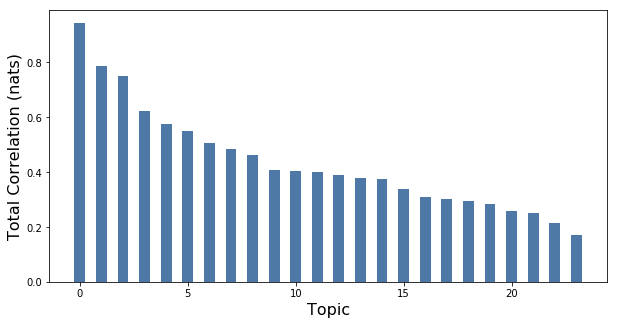

In [172]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

We see the first topic is much more informative than the other topics. Given that we suspect that this topic is picking up on image encodings (as given by "dsl" and "n3jxp" in the topic) and other boilerplate text (as given by the high TC and lack of coherence of the rest of the topic), we could consider doing additional investigation and preprocessing to help ensure that the CorEx topic model does not pick up on these patterns which are not insightful.

### Pointwise Document TC

We can decompose total correlation further. The topic correlation is the average of the pointwise total correlations for each individual document. The pointwise total correlations can be accessed through **`log_z`**.

In [173]:
topic_model.log_z.shape # n_docs x k_topics

(28213, 24)

In [174]:
print(np.mean(topic_model.log_z, axis=0))
print(topic_model.tcs)

[0.94210813 0.7848585  0.74835251 0.62308576 0.57579572 0.54959945
 0.50664567 0.48175795 0.4597337  0.40517228 0.40305948 0.39916152
 0.38858246 0.37696632 0.37368163 0.3372101  0.30974278 0.30194171
 0.29289978 0.2825093  0.25935351 0.25121712 0.21516837 0.16981587]
[0.94210813 0.7848585  0.74835251 0.62308576 0.57579572 0.54959945
 0.50664567 0.48175795 0.4597337  0.40517228 0.40305948 0.39916152
 0.38858246 0.37696632 0.37368163 0.3372101  0.30974278 0.30194171
 0.29289978 0.2825093  0.25935351 0.25121712 0.21516837 0.16981587]


The pointwise total correlations in **`log_z`** represent the correlations within an individual document explained by a particular topic. These correlations have been used to measure how "surprising" documents are with respect to given topics (see references below).

## Hierarchical Topic Models

The **`labels`** attribute gives the binary topic expressions for each document and each topic. We can use this output as input to another CorEx topic model to get latent representations of the topics themselves. This yields a hierarchical CorEx topic model. Like the first layer of the topic model, one can determine the number of latent variables to add in higher layers through examination of the topic TCs.

In [80]:
# Train a second layer to the topic model
tm_layer2 = ct.Corex(n_hidden=10)
tm_layer2.fit(topic_model.labels);

# Train a third layer to the topic model
tm_layer3 = ct.Corex(n_hidden=1)
tm_layer3.fit(tm_layer2.labels);

If you have `graphviz` installed, then you can output visualizations of the hierarchial topic model to your current working directory. One can also create custom visualizations of the hierarchy by properly making use of the **`labels`** attribute of each layer.

In [94]:
# import unicode
vis_hierarchy([topic_model, tm_layer2, tm_layer3], column_label=words, max_edges=200, prefix='topic-model-example')

from graphviz import Source
path = 'topic-model-example/graphs/graph_prune_200.dot'
s = Source.from_file(path)
s.view()

weight threshold is 0.000000 for graph with max of 200.000000 edges 
non-isolated nodes,edges 35 36
non-isolated nodes,edges 35 34
/Users/ryanalcantara/Buff Drive/Biomech_Lit_Up/literature_update/Construct_Models/tests/d3_files/force.html topic-model-example/graphs/force.html


'topic-model-example/graphs/graph_prune_200.dot.pdf'

## Anchoring for Semi-Supervised Topic Modeling

Anchored CorEx is an extension of CorEx that allows the "anchoring" of words to topics. When anchoring a word to a topic, CorEx is trying to maximize the mutual information between that word and the anchored topic. So, anchoring provides a way to guide the topic model towards specific subsets of words that the user would like to explore.  

The anchoring mechanism is flexible, and so there are many possibilities of anchoring. We explored the following types of anchoring in our TACL paper:

1. Anchoring a single set of words to a single topic. This can help promote a topic that did not naturally emerge when running an unsupervised instance of the CorEx topic model. For example, one might anchor words like "snow," "cold," and "avalanche" to a topic if one suspects there should be a snow avalanche topic within a set of disaster relief articles.

2. Anchoring single sets of words to multiple topics. This can help find different aspects of a topic that may be discussed in several different contexts. For example, one might anchor "protest" to three topics and "riot" to three other topics to understand different framings that arise from tweets about political protests.

3. Anchoring different sets of words to multiple topics. This can help enforce topic separability if there appear to be chimera topics. For example, one might anchor "mountain," "Bernese," and "dog" to one topic and "mountain," "rocky," and "colorado" to another topic to help separate topics that merge discussion of Bernese Mountain Dogs and the Rocky Mountains.


We'll demonstrate how to anchor words to the the CorEx topic model and how to develop other anchoring strategies.

In [187]:
anchor_list_list = anchor_list.to_dict('list')
# anchor_list.iloc[0]['top_words']
anchor_words = anchor_list['top_words']

In [188]:
# Anchor one word to the first topic
anchor_words


0                   [bone, fracture, model]
1               [aortic, valve, properties]
2                 [cell, cells, mechanical]
3         [performance, morphology, muscle]
4               [analysis, implant, finite]
5                  [work, lifting, effects]
6     [evolution, implications, morphology]
7                     [gait, walking, knee]
8                  [knee, cartilage, joint]
9                 [analysis, based, method]
10                 [model, finite, element]
11      [muscle, skeletal, skeletal muscle]
12              [spinal, cord, spinal cord]
13                [lumbar, spine, cervical]
14        [fixation, fractures, comparison]
15                 [foot, prosthesis, knee]
16                 [training, spinal, gait]
17                 [robot, control, robots]
18          [performance, effects, players]
19             [ligament, tendon, cruciate]
20         [tissue, properties, mechanical]
21                   [impact, head, injury]
22                [canine, dairy

In [210]:

anchored_topic_model = ct.Corex(n_hidden=n_topics, seed=2) 
anchored_topic_model.fit(doc_word, 
                         words=words, 
                         anchors=anchor_words, 
                         anchor_strength=6);
print('anchored model fit')

anchored model fit


This anchors the single word "nasa" to the first topic.

New topic: model,bone,fracture
[2.079 1.284 1.549 1.158 2.047 1.16  0.838 1.766 1.539 1.634 2.417 1.267
 2.597 1.482 2.035 1.52  1.685 1.056 1.278 2.343 1.577 1.335 0.542 1.273]
37.46194590359856


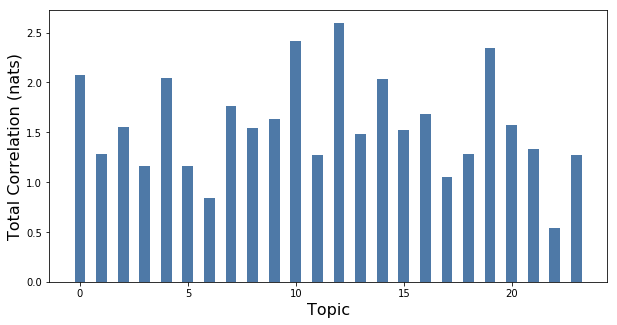

In [211]:
topic_words,_ = zip(*anchored_topic_model.get_topics(topic=0))
print('New topic: ' + ','.join(topic_words[0:3]))
print(np.round(anchored_topic_model.tcs,3))
plt.figure(figsize=(10,5))
plt.bar(range(anchored_topic_model.tcs.shape[0]), anchored_topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
print(anchored_topic_model.tc)

In [213]:
from sklearn.externals import joblib
joblib.dump(anchored_topic_model, '../Models/LDA/anchored_topic_model.pkl')
joblib.dump(vectorizer, '../Models/LDA/anchored_topic_vectorizer.pkl')

print ("Model/Vectorizer Saved")

Model/Vectorizer Saved


We can anchor multiple groups of words to multiple topics as well.

In [195]:
for n in range(len(anchor_words)):
    topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ','.join(topic_words[0:6]))

0: model,bone,fracture,healing,cortical bone,fracture healing
1: properties,aortic,valve,mechanical properties,properties human,abdominal aortic
2: mechanical,cells,cell,stem,stem cells,mesenchymal
3: muscle,performance,morphology,cross country,swimming performance,country
4: analysis,finite,implant,meta analysis,meta,gait analysis
5: effects,work,lifting,effects different,effects bone,immediate effects
6: implications,morphology,evolution,feeding,fossil,evolutionary
7: gait,knee,walking,ground reaction,ground,reaction
8: knee,joint,cartilage,osteoarthritis,articular cartilage,articular
9: analysis,based,method,image,novel method,image based
10: model,finite,element,finite element,element analysis,finite element analysis
11: muscle,skeletal,skeletal muscle,muscle activity,muscle activation,activation
12: spinal,cord,spinal cord,cord injury,spinal cord injury,recovery
13: lumbar,spine,cervical,disc,fusion,intervertebral
14: comparison,fixation,fractures,screw,plate,locking
15: knee,foot

**Choosing anchor strength:** the anchor strength controls how much weight CorEx puts towards maximizing the mutual information between the anchor words and their respective topics. Anchor strength should always be set at a value *greater than* 1, since setting anchor strength between 0 and 1 only recovers the unsupervised CorEx objective. Empirically, setting anchor strength from 1.5-3 seems to nudge the topic model towards the anchor words. Setting anchor strength greater than 5 is strongly enforcing that the CorEx topic model find a topic associated with the anchor words.

We encourage users to experiment with the anchor strength and determine what values are best for their needs.

## Further Reading

Our TACL paper details the theory of the CorEx topic model, its sparsity optimization, anchoring via the information bottleneck, comparisons to LDA, and anchoring experiments. The two papers from Greg Ver Steeg and Aram Galstyan develop the CorEx theory in general and provide further motivation and details of the underlying CorEx mechanisms. Hodas et al. demonstrated early CorEx topic model results and investigated an application of pointwise total correlations to quantify "surprising" documents.

1. [Anchored Correlation Explanation: Topic Modeling with Minimal Domain Knowledge](https://www.transacl.org/ojs/index.php/tacl/article/view/1244), Gallagher et al., TACL 2017.

2. [Discovering Structure in High-Dimensional Data Through Correlation Explanation](https://arxiv.org/abs/1406.1222), Ver Steeg and Galstyan, NIPS 2014. 

3. [Maximally Informative Hierarchical Representions of High-Dimensional Data](https://arxiv.org/abs/1410.7404), Ver Steeg and Galstyan, AISTATS 2015.

4. [Disentangling the Lexicons of Disaster Response in Twitter](https://dl.acm.org/citation.cfm?id=2741728), Hodas et al., WWW 2015.